# Imports

In [223]:
import os

# working with datasets
import kaggle
import pandas as pd
import requests

# plots and visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# learning models 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score

# Aditional plot and dataset methods

In [97]:
def show_relplot(X, Y, title, xlabel=None, ylabel=None, set_ticks=False, line_kind=False, aspect=1.0):
    sns.set_style(style='whitegrid')

    if line_kind:
        sns.relplot(x=X, y=Y, kind='line', aspect=aspect)
    else:
        sns.relplot(x=X, y=Y, aspect=aspect)


    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    if set_ticks:
        plt.xticks(rotation=45)
        plt.gca().set_xticks(X)

    plt.tight_layout()
    plt.savefig(f'plots/{title}.png')
    plt.show()

def show_scatterplot(X, Y, title, xlabel, ylabel, hue=None):
    sns.scatterplot(x=X, y=Y, hue=hue)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'plots/{title}.png')
    plt.show()

Useful methods for work with datasets

In [98]:
def download_dataset_from_kaggle(filename, dataset_path):
    if not os.path.isfile(filename):
        print(f'Downloading csv dataset from Kaggle...')
        kaggle.api.dataset_download_files(dataset_path, path='datasets', unzip=True)

    return pd.read_csv(filename)

def filter_by_year(dataset, start_year, end_year):
    if start_year > end_year:
        raise ValueError('start_year must be less than end_year')

    filtered_dataset = (dataset[
                            (dataset['Year'] >= start_year) &
                            (dataset['Year'] <= end_year)
                            ]
                        .reset_index()
                        .drop('index', axis=1))

    return filtered_dataset

# Downloading data

### Downloading datasets and checking for missing data

In this dataset there is one missing value in 1917 year witch is replaced with 0. We wont need such old data for analysis

In [99]:
def get_temperature_data():
    dataset_path = 'sarahquesnelle/canada-data'
    filename = 'datasets/Canada_Temperature_Data.csv'

    data = download_dataset_from_kaggle(filename, dataset_path)
    data['P'] = pd.to_numeric(data['P'], errors='coerce').fillna(0)

    print("Raw data:")
    print(data.info())

    # reformatting data and storing annual values
    annual_mean_temperatures = data.groupby('Year').agg({
        'Tm': 'mean',
        'S': 'sum',
        'P': 'sum'
    }).reset_index()

    annual_mean_temperatures.columns = ['Year', 'Mean Temperature', 'Total Snowfall', 'Total Precipitation']

    return annual_mean_temperatures

mean_temp_data = get_temperature_data()

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357283 entries, 0 to 1357282
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Year      1357283 non-null  int64  
 1   Month     1357283 non-null  int64  
 2   Stn_Name  1357283 non-null  object 
 3   Prov      1357283 non-null  object 
 4   Tm        1357283 non-null  float64
 5   S         1357283 non-null  float64
 6   P         1357283 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 72.5+ MB
None


In [100]:
def get_sold_cars_data():
    # gets amount of sold cars between
    url = ("https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=2010000101"
           "&latestN=0&startDate=19460101&endDate=20231201&csvLocale=en&selectedMembers=%5B%5B1%5D%2C%5B1%5D%2C%5B1"
           "%5D%2C%5B1%2C2%5D%2C%5B1%5D%5D&checkedLevels=")
    filename = "datasets/sold_cars_units_1946-2023.csv"

    if not os.path.isfile(filename):
        response = requests.get(url)

        if response.status_code == 200:
            with open(filename, "wb") as file:
                file.write(response.content)
            print("File downloaded successfully!")
        else:
            print("Failed to retrieve the file. Status code:", response.status_code)

    data = pd.read_csv(filename)

    print("Raw data:")
    print(data.info())

    # reformatting data and storing annual values
    data['Year'] = data['REF_DATE'].str.split('-').str[0]
    data['Year'] = pd.to_numeric(data['Year'])
    annual_values = data.groupby('Year')['VALUE'].sum().reset_index()
    annual_values.columns = ['Year', 'Amount']

    return annual_values

sold_cars_data = get_sold_cars_data()

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   REF_DATE               1872 non-null   object 
 1   GEO                    1872 non-null   object 
 2   DGUID                  1872 non-null   object 
 3   Vehicle type           1872 non-null   object 
 4   Origin of manufacture  1872 non-null   object 
 5   Sales                  1872 non-null   object 
 6   Seasonal adjustment    1872 non-null   object 
 7   UOM                    1872 non-null   object 
 8   UOM_ID                 1872 non-null   int64  
 9   SCALAR_FACTOR          1872 non-null   object 
 10  SCALAR_ID              1872 non-null   int64  
 11  VECTOR                 1872 non-null   object 
 12  COORDINATE             1872 non-null   object 
 13  VALUE                  1872 non-null   int64  
 14  STATUS                 0 non-null      float64

In [101]:
def get_fuel_consumption():
    dataset_path = 'ahmettyilmazz/fuel-consumption'
    filename = 'datasets/Fuel_Consumption_2000-2022.csv'

    data = download_dataset_from_kaggle(filename, dataset_path)

    print("Raw data:")
    print(data.info())

    # reformatting data in columns
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.upper()
    data['VEHICLE CLASS'] = data['VEHICLE CLASS'].str.replace(': ', ' - ')

    return data

cars_and_fuel_con = get_fuel_consumption()
""" cars_and_fuel_con.rename(columns={'YEAR':'Year',
                                  'MAKE':'Make',
                                  'MODEL':'Model',
                                  'VEHICLE CLASS':'Vehicle Class',
                                  'ENGINE SIZE':'Engine size',
                                  'CYLINDERS':'Cylinders',
                                  'TRANSMISSION':'Transmission',
                                  'FUEL':'Fuel',
                                  'FUEL CONSUMPTION':'Fuel Consumption',
                                  'EMISSIONS ': 'Emissions'
                                  }, inplace=True)
"""

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              22556 non-null  int64  
 1   MAKE              22556 non-null  object 
 2   MODEL             22556 non-null  object 
 3   VEHICLE CLASS     22556 non-null  object 
 4   ENGINE SIZE       22556 non-null  float64
 5   CYLINDERS         22556 non-null  int64  
 6   TRANSMISSION      22556 non-null  object 
 7   FUEL              22556 non-null  object 
 8   FUEL CONSUMPTION  22556 non-null  float64
 9   HWY (L/100 km)    22556 non-null  float64
 10  COMB (L/100 km)   22556 non-null  float64
 11  COMB (mpg)        22556 non-null  int64  
 12  EMISSIONS         22556 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.2+ MB
None


" cars_and_fuel_con.rename(columns={'YEAR':'Year',\n                                  'MAKE':'Make',\n                                  'MODEL':'Model',\n                                  'VEHICLE CLASS':'Vehicle Class',\n                                  'ENGINE SIZE':'Engine size',\n                                  'CYLINDERS':'Cylinders',\n                                  'TRANSMISSION':'Transmission',\n                                  'FUEL':'Fuel',\n                                  'FUEL CONSUMPTION':'Fuel Consumption',\n                                  'EMISSIONS ': 'Emissions'\n                                  }, inplace=True)\n"

In [102]:
def get_demographics():
    url = 'https://en.wikipedia.org/wiki/Demographics_of_Canada'
    filename = 'datasets/Demographics_of_Canada.csv'

    if not os.path.isfile(filename):
        dfs = pd.read_html(url, header=0)
        
        for df in dfs:
            if 'Average population (on July 1)' in df.columns:

                df = df.iloc[:, :2]
                df.columns = ['Year', 'Average Population']
    
                df.to_csv(filename, index=False)
                break

    return pd.read_csv(filename)

demographics_data = get_demographics()

In [103]:
cars_and_fuel_con.head()

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


In [104]:
sold_cars_data.head()

,Year,Amount
0,1946,313373
1,1947,646494
2,1948,660518
3,1949,875066
4,1950,1315365


In [105]:
mean_temp_data.head()

,Year,Mean Temperature,Total Snowfall,Total Precipitation
0,1917,3.397697,71993.4,282321.6
1,1918,4.601561,61197.0,299492.6
2,1919,4.422720,62713.9,294860.5
3,1920,4.473663,66841.0,299336.7
4,1921,5.045527,67793.2,323221.2


In [106]:
demographics_data.head()

,Year,Average Population
0,1900,5500000
1,1901,5600000
2,1902,5760000
3,1903,5930000
4,1904,6100000


# Checking for missing data


In [107]:
cars_and_fuel_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              22556 non-null  int64  
 1   MAKE              22556 non-null  object 
 2   MODEL             22556 non-null  object 
 3   VEHICLE CLASS     22556 non-null  object 
 4   ENGINE SIZE       22556 non-null  float64
 5   CYLINDERS         22556 non-null  int64  
 6   TRANSMISSION      22556 non-null  object 
 7   FUEL              22556 non-null  object 
 8   FUEL CONSUMPTION  22556 non-null  float64
 9   HWY (L/100 km)    22556 non-null  float64
 10  COMB (L/100 km)   22556 non-null  float64
 11  COMB (mpg)        22556 non-null  int64  
 12  EMISSIONS         22556 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.2+ MB


In [108]:
sold_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    78 non-null     int64
 1   Amount  78 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


In [109]:
mean_temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 101 non-null    int64  
 1   Mean Temperature     101 non-null    float64
 2   Total Snowfall       101 non-null    float64
 3   Total Precipitation  101 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.3 KB


In [110]:
demographics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                124 non-null    int64
 1   Average Population  124 non-null    int64
dtypes: int64(2)
memory usage: 2.1 KB


There is no missing data so we dont need to handle it.

# Dependencies between data

### Amount of sold cars

In [111]:
start_year = 2000
end_year = 2022

sold_cars_filtered = filter_by_year(sold_cars_data, start_year, end_year)
sold_cars_filtered.head()

,Year,Amount
0,2000,48518075
1,2001,48484216
2,2002,53960817
3,2003,52119776
4,2004,51214418


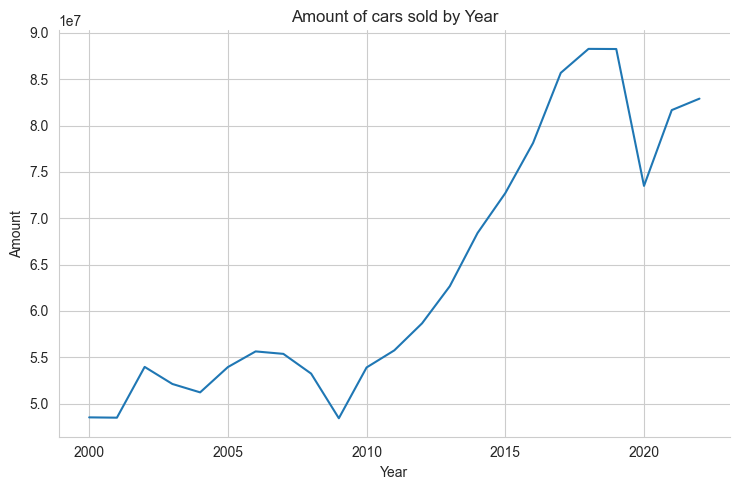

In [112]:
show_relplot(sold_cars_filtered['Year'], sold_cars_filtered['Amount'], 'Amount of cars sold by Year', line_kind=True, aspect=1.5)

### Mean temperatures

In [113]:
# MEAN TEMPERATURE VALUES
start_year = 2000
end_year = 2017

mean_temp_filtered = filter_by_year(mean_temp_data, start_year, end_year)
mean_temp_filtered.head()

,Year,Mean Temperature,Total Snowfall,Total Precipitation
0,2000,4.275210,247356.0,1184941.1
1,2001,5.121442,219202.8,1056534.5
2,2002,4.126670,242017.8,1027263.1
3,2003,4.374958,220364.3,1032865.3
4,2004,3.727522,204710.4,903349.4


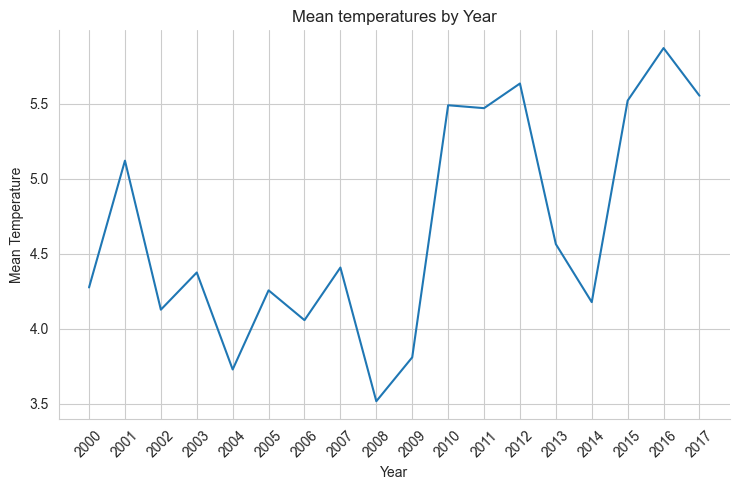

In [114]:
show_relplot(mean_temp_filtered['Year'], mean_temp_filtered['Mean Temperature'], 'Mean temperatures by Year', set_ticks=True, line_kind=True, aspect=1.5)

### Mean temperatures vs Total precipitation

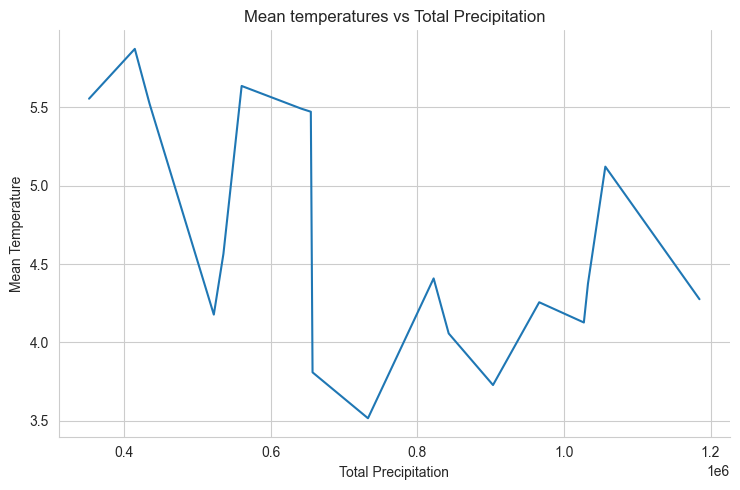

In [115]:
show_relplot(mean_temp_filtered['Total Precipitation'], mean_temp_filtered['Mean Temperature'], 'Mean temperatures vs Total Precipitation', line_kind=True, aspect=1.5)

### Average population

In [116]:
start_year = 2000
end_year = 2023

demographics_filtered = filter_by_year(demographics_data, start_year, end_year)
demographics_filtered.head()

,Year,Average Population
0,2000,30685730
1,2001,31020902
2,2002,31360079
3,2003,31644028
4,2004,31940655


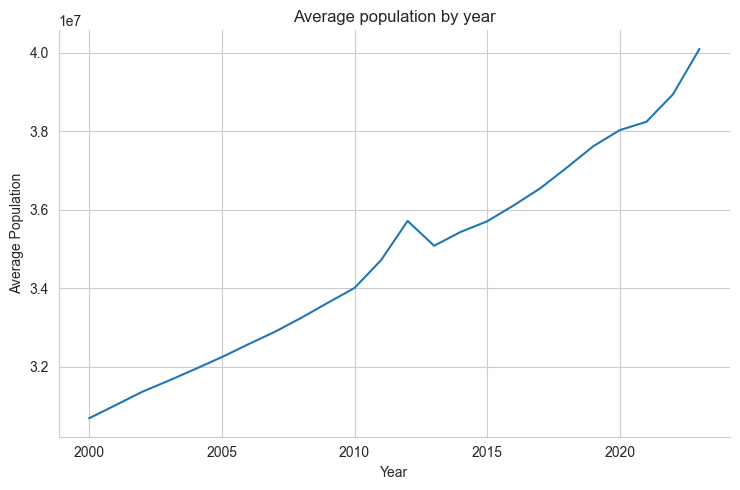

In [117]:
show_relplot(demographics_filtered['Year'], demographics_filtered['Average Population'], 'Average population by year', line_kind=True, aspect=1.5)

### Engine size with fuel consumption

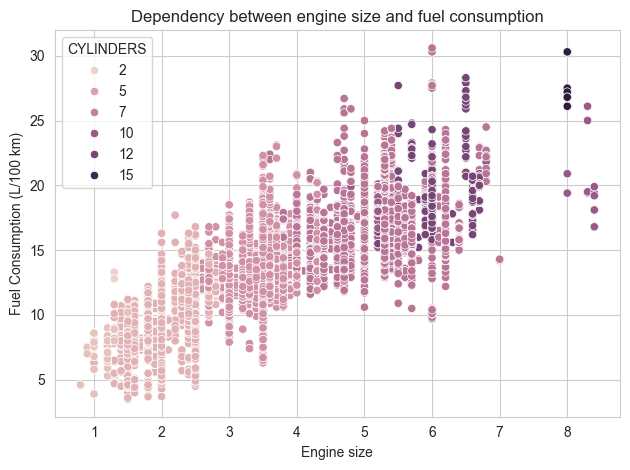

In [118]:
show_scatterplot(cars_and_fuel_con['ENGINE SIZE'], cars_and_fuel_con['FUEL CONSUMPTION'], 'Dependency between engine size and fuel consumption', xlabel='Engine size', ylabel='Fuel Consumption (L/100 km)', hue=cars_and_fuel_con['CYLINDERS'])

### Fuel consumption with emissions

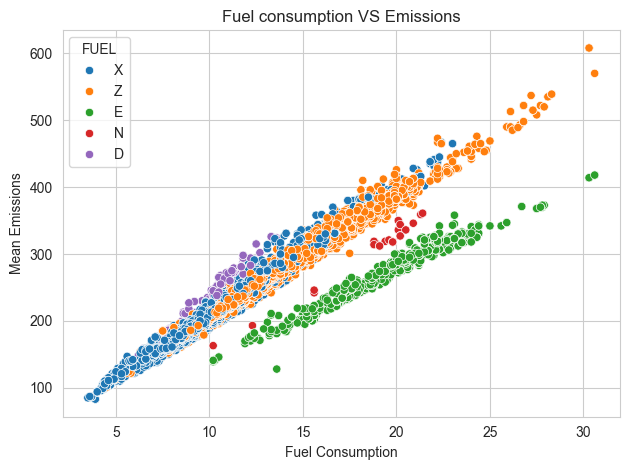

In [119]:
show_scatterplot(cars_and_fuel_con['FUEL CONSUMPTION'], cars_and_fuel_con['EMISSIONS'], 'Fuel consumption VS Emissions', 'Fuel Consumption', 'Mean Emissions', cars_and_fuel_con['FUEL'])

### Yearly emissions

In [120]:
# Yearly emissions
yearly_emissions = cars_and_fuel_con.groupby('YEAR')['EMISSIONS'].mean().reset_index()
yearly_emissions.columns = ['Year', 'Mean Emissions']

yearly_emissions.head()

,Year,Mean Emissions
0,2000,259.696401
1,2001,256.901325
2,2002,263.435135
3,2003,261.028049
4,2004,261.871938


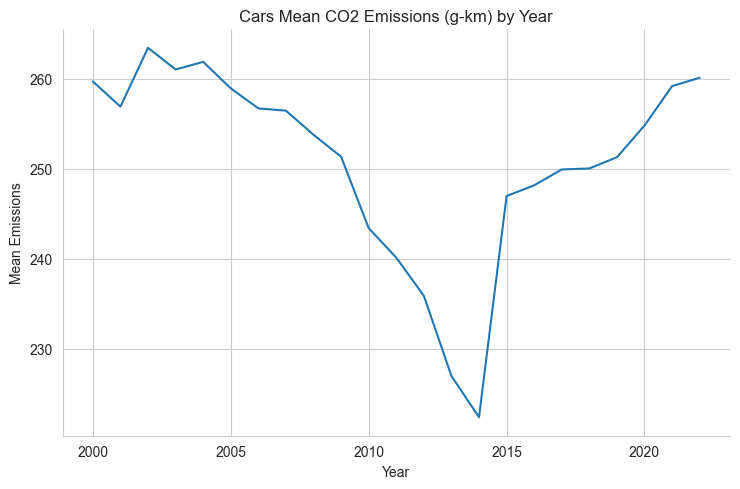

In [121]:
show_relplot(yearly_emissions['Year'], yearly_emissions['Mean Emissions'], 'Cars Mean CO2 Emissions (g-km) by Year', line_kind=True, aspect=1.5)

### Dependency between amount of car emissions and mean temperature

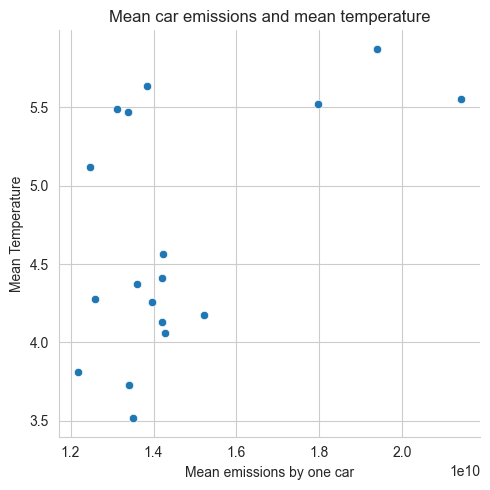

In [122]:
X = yearly_emissions['Mean Emissions'] * sold_cars_filtered['Amount']
Y = mean_temp_filtered['Mean Temperature']

show_relplot(X, Y, 'Mean car emissions and mean temperature', 'Mean emissions by one car')

### Emissions made in every year

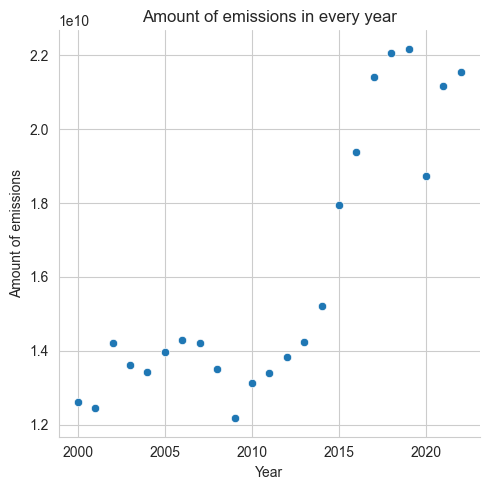

In [123]:
X = yearly_emissions['Year']
Y = yearly_emissions['Mean Emissions'] * sold_cars_filtered['Amount']

show_relplot(X, Y, 'Amount of emissions in every year', ylabel='Amount of emissions')

### Dependency between population and amount of produced cars


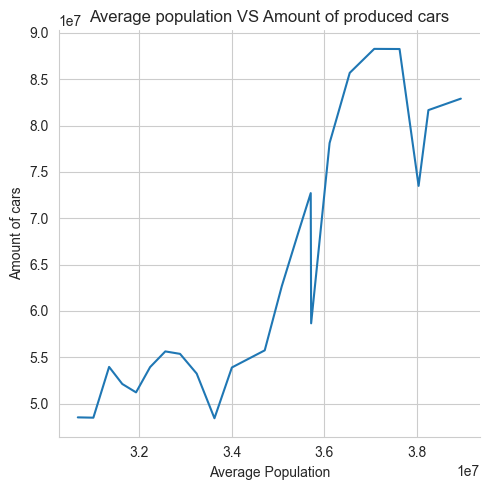

In [124]:
X = demographics_filtered['Average Population']
Y = sold_cars_filtered['Amount']

show_relplot(X, Y, 'Average population VS Amount of produced cars', ylabel='Amount of cars', line_kind=True)

### Dependency between population and mean temperature


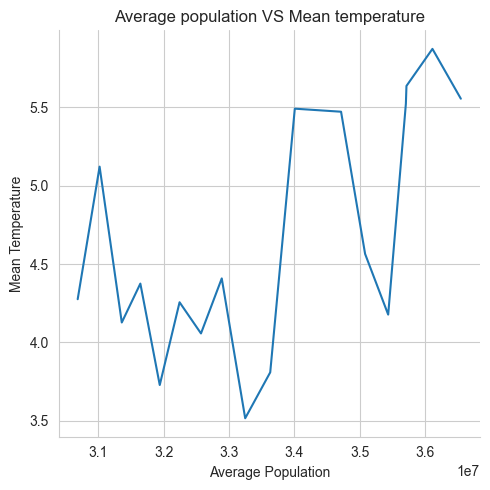

In [125]:
X = demographics_filtered['Average Population']
Y = mean_temp_filtered['Mean Temperature']

show_relplot(X, Y, 'Average population VS Mean temperature', line_kind=True)

### Dependency between population and amount of emissions


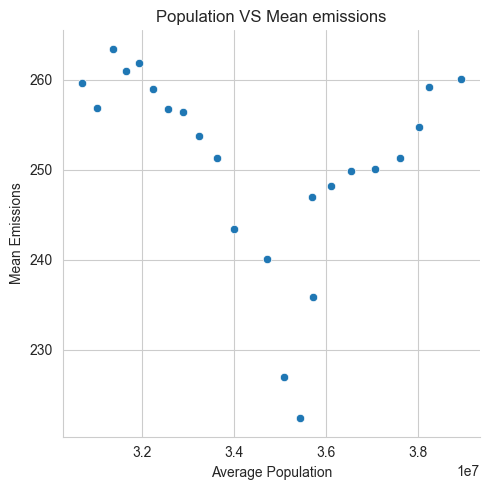

In [126]:
X = demographics_filtered['Average Population']
Y = yearly_emissions['Mean Emissions'] 

show_relplot(X, Y, 'Population VS Mean emissions')

### Dependency between Precipitation and amount of emissions

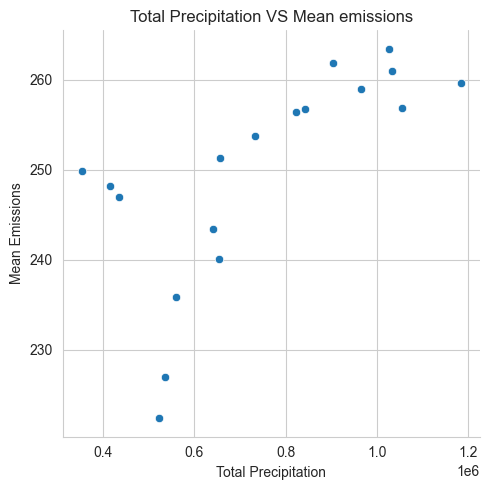

In [127]:
X = mean_temp_filtered['Total Precipitation']
Y = yearly_emissions['Mean Emissions']

show_relplot(X, Y, 'Total Precipitation VS Mean emissions')

# Data preprocessing


### Reformating data

In this dataset we will contain all needed data. Because we have annual values for temperatures, precipitation and population, every year will store same value for one year

In [128]:
cars_and_fuel_con.rename(columns={'YEAR': 'Year'}, inplace=True)
full_data = pd.merge(cars_and_fuel_con, mean_temp_data, on='Year', how='left')
full_data = pd.merge(full_data, demographics_data, on='Year', how='left')

full_data.head()


,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,Mean Temperature,Total Snowfall,Total Precipitation,Average Population
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186,4.27521,247356.0,1184941.1,30685730
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175,4.27521,247356.0,1184941.1,30685730
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230,4.27521,247356.0,1184941.1,30685730
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264,4.27521,247356.0,1184941.1,30685730
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198,4.27521,247356.0,1184941.1,30685730


In [129]:
full_data = filter_by_year(full_data, 2000, 2017)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17553 entries, 0 to 17552
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 17553 non-null  int64  
 1   MAKE                 17553 non-null  object 
 2   MODEL                17553 non-null  object 
 3   VEHICLE CLASS        17553 non-null  object 
 4   ENGINE SIZE          17553 non-null  float64
 5   CYLINDERS            17553 non-null  int64  
 6   TRANSMISSION         17553 non-null  object 
 7   FUEL                 17553 non-null  object 
 8   FUEL CONSUMPTION     17553 non-null  float64
 9   HWY (L/100 km)       17553 non-null  float64
 10  COMB (L/100 km)      17553 non-null  float64
 11  COMB (mpg)           17553 non-null  int64  
 12  EMISSIONS            17553 non-null  int64  
 13  Mean Temperature     17553 non-null  float64
 14  Total Snowfall       17553 non-null  float64
 15  Total Precipitation  17553 non-null 

I'll choose period since 2000 - 2017 year because int this scenario we have all needed data

In [172]:
full_data = filter_by_year(full_data, 2000, 2017)

Some of columns are unrelevant so we need to drop it. Also I'm droping another consumption columns because they are calculated based on FUEL CONSUMPTION column

In [131]:
columns_to_drop = ['MAKE','VEHICLE CLASS', 'MODEL', 'TRANSMISSION', 'HWY (L/100 km)', 'COMB (L/100 km)', 'COMB (mpg)']

full_data.drop(columns_to_drop, axis=1, inplace=True)

Before creating models we need to remap FUEL columns to numeric data. Every fuel type will be remaped to integers
 - 1 - X = Regular gasoline
 - 2 - Z = Premium gasoline
 - 3 - D = Diesel
 - 4 - E = Ethanol (E85)
 - 5 - N = Natural Gas

In [132]:
fuel_map = {'X': 1, 'Z': 2, 'D': 3, 'E': 4, 'N': 5}

full_data['FUEL'] = full_data['FUEL'].map(fuel_map)

In [133]:
full_data.head()

,Year,ENGINE SIZE,CYLINDERS,FUEL,FUEL CONSUMPTION,EMISSIONS,Mean Temperature,Total Snowfall,Total Precipitation,Average Population
0,2000,1.6,4,1,9.2,186,4.27521,247356.0,1184941.1,30685730
1,2000,1.6,4,1,8.5,175,4.27521,247356.0,1184941.1,30685730
2,2000,3.2,6,2,12.2,230,4.27521,247356.0,1184941.1,30685730
3,2000,3.5,6,2,13.4,264,4.27521,247356.0,1184941.1,30685730
4,2000,1.8,4,1,10.0,198,4.27521,247356.0,1184941.1,30685730


In [173]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17553 entries, 0 to 17552
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 17553 non-null  int64  
 1   ENGINE SIZE          17553 non-null  float64
 2   CYLINDERS            17553 non-null  int64  
 3   FUEL                 17553 non-null  int64  
 4   FUEL CONSUMPTION     17553 non-null  float64
 5   EMISSIONS            17553 non-null  int64  
 6   Mean Temperature     17553 non-null  float64
 7   Total Snowfall       17553 non-null  float64
 8   Total Precipitation  17553 non-null  float64
 9   Average Population   17553 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 1.3 MB


# Creating models

## Linear Regresion

In [239]:
X = full_data[['Year','ENGINE SIZE','CYLINDERS','FUEL','EMISSIONS','Mean Temperature','Total Snowfall','Total Precipitation','Average Population']]
Y = full_data['FUEL CONSUMPTION']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

model_lin = LinearRegression()
model_lin.fit(X_train, Y_train)

predicted = model_lin.predict(X_test)

In [251]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(13164, 9) (4389, 9) (13164,) (4389,)


In [240]:
mean_absolute_error(Y_test, predicted)

0.677338151532337

In [241]:
mean_squared_error(Y_test, predicted)

0.8540410164680144

In [242]:
root_mean_squared_error(Y_test, predicted)

0.9241433960528065

In [249]:
r2_score(Y_test, predicted)

0.9305706458658075

In [244]:
model_lin.coef_

array([-1.37942268e-01,  4.66133710e-01, -1.92100117e-01,  1.35124274e+00,
        4.83925471e-02, -1.52729654e-01, -3.67335187e-06,  5.15182179e-07,
        3.25950667e-07])

In [245]:
model_lin.intercept_

265.22039915208745

In [246]:
Y_test.info()

<class 'pandas.core.series.Series'>
Index: 4389 entries, 5237 to 1660
Series name: FUEL CONSUMPTION
Non-Null Count  Dtype  
--------------  -----  
4389 non-null   float64
dtypes: float64(1)
memory usage: 68.6 KB


In [247]:
Y_test

5237     17.2
1657     16.0
2277     19.1
11805    12.2
1343     15.3
         ... 
5410      9.2
5465     12.3
14286    12.8
13782    15.6
1660     16.3
Name: FUEL CONSUMPTION, Length: 4389, dtype: float64

In [248]:
Y_train.info()

<class 'pandas.core.series.Series'>
Index: 13164 entries, 14311 to 14979
Series name: FUEL CONSUMPTION
Non-Null Count  Dtype  
--------------  -----  
13164 non-null  float64
dtypes: float64(1)
memory usage: 205.7 KB


In [212]:
Y_train

6563     11.9
6796     13.6
11322    17.7
3591     10.9
344      10.0
         ... 
1147     11.5
3506     11.7
13122    12.7
1834     10.1
2356      9.3
Name: FUEL CONSUMPTION, Length: 13164, dtype: float64

In [213]:
len(predicted)

4389

Deviation of predicted values

In [254]:
deviation = Y_test - predicted
deviation.info()

<class 'pandas.core.series.Series'>
Index: 4389 entries, 5237 to 1660
Series name: FUEL CONSUMPTION
Non-Null Count  Dtype  
--------------  -----  
4389 non-null   float64
dtypes: float64(1)
memory usage: 197.6 KB


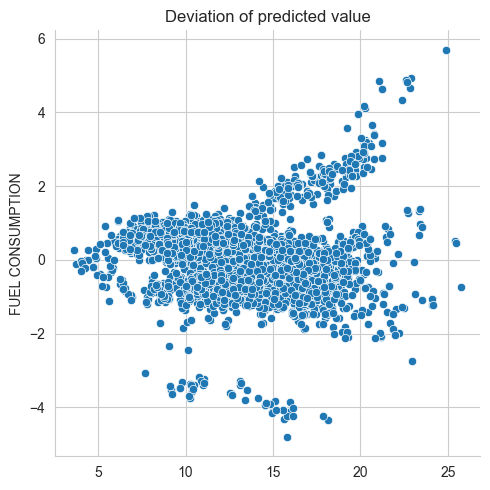

In [255]:
show_relplot(predicted, deviation, "Deviation of predicted value")

## Generalized Linear Model